In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import pickle
pd.options.display.max_columns = 100

In [29]:
import numpy as np
import time

def construct_pred_datasets(the_dict, **kwargs):
    if 'train' in the_dict and 'test' in the_dict:
        result_dict = {}
        result_dict['train'] = _construct_pred_datasets(the_dict['train'], **kwargs)
        result_dict['test'] = _construct_pred_datasets(the_dict['test'], **kwargs)
        return result_dict
    
    return _construct_pred_datasets(the_dict, **kwargs)

def _construct_pred_datasets(the_dict, n_hours_ahead=6, 
                            n_x_prediction=24, interval_hours=1, n_hours_ahead_for_gp=6, 
                            n_hours_min_len=6, least_num_y=10, selected_attrs_dict=None):
    '''
    Construct the prediction datasets
    @params n_hours_ahead: the interval time to do early-prediction
    @params n_x_prediction: num of x to put in RNN. Each x is 1-hour interval, which takes 48 hour input
    @params n_hours_ahead_for_gp: take more inputs to do better imputation for x.
    
    # We want to take more time points to impute the value for x. So take more inputs ahead.
    '''
    
    start_time = time.time()
    
    new_dict = dict([(k, []) for k in ['Ys', 'Ts', 'ind_kts', 'ind_kfs', 'Xs', 'labels']])
    new_dict['feature_names'] = the_dict['feature_names']
    
    all_y_len = []

    for i in range(len(the_dict['Ys'])):

        x_end_time = the_dict['rel_end_time'][i] - n_hours_ahead
        x_start_time = max(x_end_time - n_x_prediction * interval_hours, 0)
        
        if x_end_time <= (x_start_time + n_hours_min_len):
            continue

        # Figure out the y_start_time
        y_start_time = x_start_time - n_hours_ahead_for_gp

        theY, the_idx_t, the_idx_f, theT = [], [], [], []
        for ind_t, ind_f, y in zip(the_dict['ind_kts'][i], the_dict['ind_kfs'][i], the_dict['Ys'][i]):
            hour = the_dict['Ts'][i][ind_t]
            if hour < y_start_time or hour > x_end_time:
                continue
                
            if selected_attrs_dict is not None:
                feature_name = idx_to_feature_name[ind_f]
                if feature_name not in selected_attrs_dict:
                    continue
                
                ind_f = selected_attrs_dict[feature_name]
            
            theY.append(y)
            the_idx_f.append(ind_f)

            if len(theT) == 0 or hour != theT[-1]:
                theT.append(hour)

            the_idx_t.append(len(theT) - 1)
        
        if len(theY) > least_num_y:
            xs = np.arange(x_end_time, x_start_time, -1)[::-1]
            new_dict['Xs'].append(xs)
            
            all_y_len.append(len(theY))
            new_dict['Ys'].append(theY)
            new_dict['ind_kts'].append(the_idx_t)
            new_dict['ind_kfs'].append(the_idx_f)
            new_dict['Ts'].append(theT)
            new_dict['labels'].append(the_dict['labels'][i])
    print('spend time:', time.time() - start_time)
    
    plt.hist(all_y_len, bins=100, range=(0, 500))
    plt.show()
    
    return new_dict

def plot_measurement_by_dict(the_dict, idx):
    plot_measurement(*[the_dict[k][idx] for k in ['Ys', 'ind_kfs', 'ind_kts', 'Ts', 'Xs']],
                     names=the_dict['feature_names'])

def plot_measurement(y, ind_kf, ind_kt, t, x=None, names=None, y_upper=None, y_lower=None):
    num_features = max(ind_kf) + 1

    f, axarr = plt.subplots(num_features + 1, sharex=True, figsize=(20, 15))
    for m in range(num_features):
        if names is not None:
            axarr[m].set_xlabel(names[m])
        
        idx = [i for i, x in enumerate(ind_kf) if x == m]
        if len(idx) > 0:
            x_ = np.array([t[ind_kt[i]] for i in idx])
            y_ = np.array([y[i] for i in idx])

            axarr[m].scatter(x_, y_)
            
            if y_upper is not None and y_lower is not None:
                y_lower_ = np.array([y_lower[i] for i in idx])
                y_upper_ = np.array([y_upper[i] for i in idx])
                axarr[m].fill_between(x_, y_lower_, y_upper_, alpha=0.1)
    
    if x is not None:
        axarr[-1].scatter(x, [0 for i in range(len(x))])
        axarr[-1].set_xlabel('x')

## Load data

In [3]:
data_dict = pickle.load(open('../data/my-mortality/norm_10features_hard.pkl', 'rb'))

spend time: 4.009161949157715


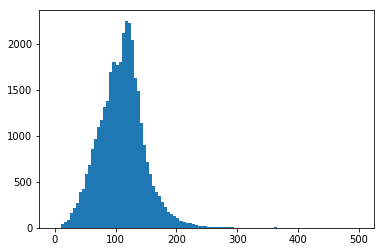

spend time: 0.580655574798584


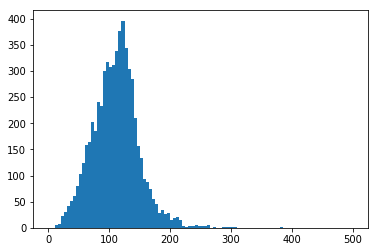

In [34]:
n_hours_ahead = 2
result_dict = construct_pred_datasets(data_dict, n_hours_ahead=n_hours_ahead, 
                        n_x_prediction=24, interval_hours=1, n_hours_ahead_for_gp=6, 
                        n_hours_min_len=6, least_num_y=10, selected_attrs_dict=None)

path = os.path.join('../data/my-mortality/0416/', '0416_10f_%dhrs.pkl' % n_hours_ahead)
pickle.dump(result_dict, open(path, 'wb'))

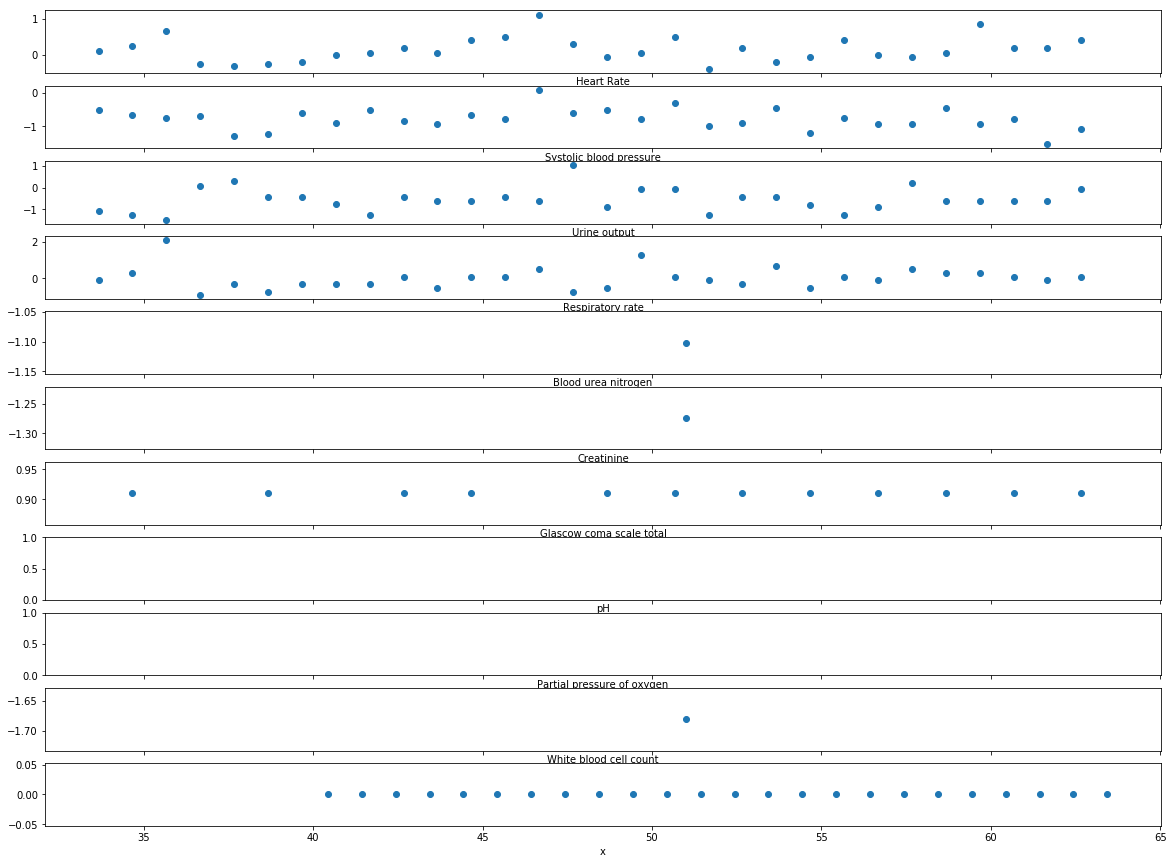

In [21]:
plot_measurement_by_dict(result_dict['train'], 20)